<a href="https://colab.research.google.com/github/talw98/TEXT-CLASSIFICATION-WITH-BERT/blob/main/MTalhaWaqas_Lab3_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification with BERT

ASSIGNMENT DONE BY: MUHAMMAD TALHA WAQAS

## What is text classification?

There are three classic tasks in NLP:

1) Text generation (next work prediction)

2) Text translation (sequence to sequence)

3) Text classification (sequence to label)

This lab focuses on the last task. Given a corpus and a set of labels, can we learn a model to predict labels based on the text?

Example: given a Tweet from Taylor Swift, predict how many likes it will receive.

Example: given a transcript of a speech by Joe Biden, predict which speechwriter wrote it.

**Question**: Give three examples of text classification in the bio-medical domain.

**Answer**:


1. Disease Diagnosis from Clinical Notes
2. Drug Repurposing
3. Biological Entity Recognition in Text

Prior to Transformers, there were various models used for text classification. For example, LSTM reads procsses texts token by token, with a single hidden state getting updated after reading each token. Furthermore, simpler models like regression from TF-IDF can be useful in some contexts. In this lab, we will first consider a simple TF-IDF model, then compare it with SOTA BERT models.

In [ ]:
#load libraries necessary for TF-IDF classification
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import re
import matplotlib.pyplot as plt

In [ ]:
#load corpus
df = pd.read_csv("covid_df.csv")
df = df.sample(len(df))

## Train-test split

Before we perform any classification problem, it is important to perform a splitting of the data into train and test (and validation) sets. There are two general, common frameworks for dataset splitting:

1) We learn our classification function based on the train set, then evaluate its goodness using the test set.

2) We train several classification functions based on the train set, then choose the best one based on the validation set. We then evaluate the overall goodness of the function based on its test set performance.

The first strategy is useful if you know exactly which classification function you want. The latter is useful if there are any hyper-parameters you aren't sure about (for example: learning rate, tokenization strategy, etc.).

We consider several important statistics for each model:

• Train/validation/test accuracy (or more sophisticated accuracy measures): the rate of accurate predictions of the model. We try and maximize this.

• Train/validation/test loss: the quantity of loss, if we define an explicit loss function. We try and minimize this.



**Question**: In your own words, explain why it is important to use data splitting. Furthermore, explain why an algorithm that achieves 100% training accuracy is not always a good algorithm.

**ANSWER**:

Data splitting is a crucial practice in machine learning for assessing a model's ability to generalize beyond the training set. By dividing the dataset into training, validation, and test sets, we can train the model on one subset, tune its hyperparameters on another, and finally evaluate its performance on unseen data. This process helps ensure that the model can make accurate predictions on new instances.

An algorithm achieving 100% training accuracy implies that it has successfully learned the patterns present in the training data. However, this does not guarantee good performance on unseen data. The risk is that the model may have memorized noise or outliers in the training set, a phenomenon known as overfitting. Overfit models fail to generalize well, leading to poor performance when applied to new, unseen examples.

In essence, while high training accuracy is desirable, it's not sufficient. The ultimate goal is a model that not only fits the training data well but also generalizes effectively to new, unseen data. The validation and test sets play a critical role in ensuring the model's robustness and reliability in real-world applications.

**Question**: Write a function that assigns a column Split (see below):



In [ ]:
def assign_train_test_split(df, train_size=0.8, valid_size=0.1, random_state=None):
    df['Split'] = "Test"
    train_indices = df.sample(frac=train_size, random_state=random_state).index
    df.loc[train_indices, 'Split'] = "Train"

    nb_valid = int(valid_size * len(df))
    valid_indices = df.loc[df['Split'] == "Test"].sample(n=nb_valid, random_state=random_state).index
    df.loc[valid_indices, 'Split'] = "Valid"

    return df

# Example usage:
df = pd.read_csv("covid_df.csv")
df = assign_train_test_split(df, train_size=0.8, valid_size=0.1, random_state=42)
df





,doc_id,Title,Abstract,Year,Split
0,37972180,"Humans are biocultural, science should be too.",COVID-19 is restructuring societies. Lonelines...,2023,Train
1,37972171,The responsibility turn,Lessons from the COVID-19 pandemic inspire a g...,2023,Valid
2,37943961,Correction is courageous.,In a year when disagreements over scientific m...,2023,Train
3,37943932,Open science discovery of potent noncovalent S...,"We report the results of the COVID Moonshot, a...",2023,Train
4,37943911,Preparing for the next pandemic.,New lead drugs to treat COVID-19 are beginning...,2023,Train
...,...,...,...,...,...
328,32198291,Crystal structure of SARS-CoV-2 main protease ...,The coronavirus disease 2019 (COVID-19) pandem...,2020,Train
329,32179701,Substantial undocumented infection facilitates...,Estimation of the prevalence and contagiousnes...,2020,Train
330,32144116,The effect of travel restrictions on the sprea...,Motivated by the rapid spread of coronavirus d...,2020,Train
331,32132184,Structural basis for the recognition of SARS-C...,Angiotensin-converting enzyme 2 (ACE2) is the ...,2020,Test


In [ ]:
#Did your function work?
# Assertion checks
assert np.fabs(len(df[df["Split"] == "Train"]) - len(df) * 0.8) < 10
assert np.fabs(len(df[df["Split"] == "Valid"]) - len(df) * 0.1) < 10
assert np.fabs(len(df[df["Split"] == "Test"]) - len(df) * 0.1) < 10


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm") #this could take a minute to download the first time

In [ ]:
def clean(sentence):
    sentence = nlp(sentence)
    ret = []
    for word in sentence:
        if word.is_stop: continue
        lem = word.lemma_
        ret.append(lem)
    spacy_cleaned = " ".join(ret)
    sent = re.sub('[^A-Za-z]', ' ', spacy_cleaned)
    sent = re.sub('\s+', ' ', sent)
    return sent

df["Abstract_Cleaned"] = df["Abstract"].apply(clean)

## TF-IDF classifier

The task at hand is to predict the year of each article based on its abstract. We hypothesize that there is temporal vocabulary change that occurs when talking about COVID-19, such that certain terms, phrases, or ways of speaking about the disease will change over time. We will first use a simpler method for this - classification using TF-IDF vectors.



In [ ]:
def get_tfidf_vectors_and_labels(df, split = "Train", max_features = 100):
    #new TF-IDF vectorizer considering only the 1000 most common terms
    vectorizer = TfidfVectorizer(max_features=max_features)
    #compute the TF-IDF vectors for each cleaned abstract
    vectorizer.fit(df[df.Split=="Train"]["Abstract_Cleaned"])
    vectors = vectorizer.transform(df[df.Split==split]["Abstract_Cleaned"])

    labels = df[df.Split==split]["Year"]
    return vectors.toarray(), labels

**Question**: Describe the vocabulary terms recovered by TF-IDF vectorization. Are there any numbers? Why not

*hint: use the get_feature_names_out method*

In [ ]:
def get_tfidf_vectors_and_labels(df, split="Train", max_features=100):
    # New TF-IDF vectorizer considering only the specified number of most common terms
    vectorizer = TfidfVectorizer(max_features=max_features)

    # Compute the TF-IDF vectors for each cleaned abstract in the training set
    vectorizer.fit(df[df.Split == "Train"]["Abstract_Cleaned"])

    # Get the TF-IDF vectors for the specified split
    vectors = vectorizer.transform(df[df.Split == split]["Abstract_Cleaned"]).toarray()

    # Get the labels for the specified split
    labels = df[df.Split == split]["Year"]


    return vectors, labels


train_vectors, train_labels = get_tfidf_vectors_and_labels(df, split="Train", max_features=100)



In [ ]:
vectorizer = TfidfVectorizer(max_features=100)
vectorizer.fit(df[df.Split == "Train"]["Abstract_Cleaned"])

vocabulary = vectorizer.get_feature_names_out()
vocabulary


array(['ace', 'activity', 'acute', 'age', 'analysis', 'animal',
       'antibodie', 'antibody', 'antiviral', 'ba', 'bind', 'case',
       'cause', 'cell', 'change', 'china', 'clinical', 'concern',
       'contact', 'control', 'coronavirus', 'country', 'cov', 'covid',
       'datum', 'death', 'delta', 'design', 'disease', 'domain', 'dose',
       'drug', 'early', 'effect', 'epidemic', 'epitope', 'escape',
       'estimate', 'find', 'future', 'global', 'health', 'high', 'human',
       'identify', 'immune', 'immunity', 'include', 'increase',
       'individual', 'infect', 'infection', 'intervention', 'lead',
       'level', 'low', 'model', 'mrna', 'mutation', 'need',
       'neutralization', 'neutralize', 'new', 'omicron', 'pandemic',
       'patient', 'population', 'protein', 'provide', 'public', 'rbd',
       'receptor', 'reduce', 'report', 'respiratory', 'response',
       'result', 'reveal', 'rna', 'sars', 'severe', 'show', 'spike',
       'spread', 'structure', 'study', 'syndrome', 

There are no numbers because the default token pattern in scikit-learn's TfidfVectorizer considers only words with two or more characters

**Question**: Visualize the distribution of years.

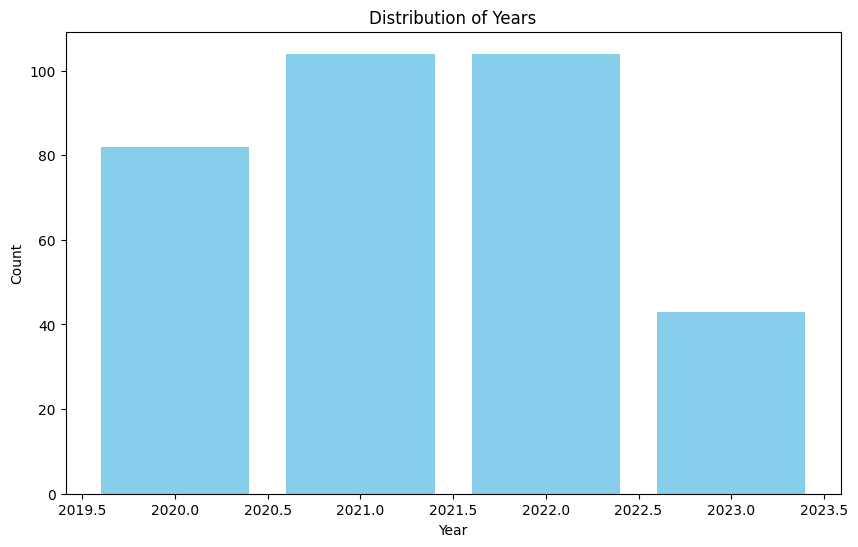

In [ ]:
#todo: year visualization (hint: use a bar graph!)
import matplotlib.pyplot as plt

years_distribution = df["Year"].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(years_distribution.index, years_distribution.values, color='skyblue')
plt.title('Distribution of Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()


We have several choices of metric to measure the performance of our classifier. The most obvious is accuracy - simply the number of correct predictions over the number of total predictions. However, this metric is less interesting for unabalanced classes (as we have in this case).

**Question**: give an example of a classification problem in which the accuracy metric is misleadingly optimistic.

**ANSWER**:In fraud detection, where fraudulent transactions are rare compared to legitimate ones, the accuracy metric can be misleadingly optimistic. If the majority of transactions are legitimate, a model that predicts all transactions as legitimate (classifies everything as the majority class) would still achieve a high accuracy because it correctly predicts the majority class in the imbalanced dataset. However, such a model would be ineffective at identifying fraudulent transactions, making accuracy an inadequate metric for evaluating its performance in this context.



Therefore, in NLP classification problems, we typically use the F1-score, which is the harmonic mean between precision and recall. This gives us a more nuanced picture of our classifier's performance over all the classes. There are several flavours of F1 score, most notably "macro" and "weighted" - the former weights each class equally, while the latter weights each class according to its prevalence, giving higher weight to more prevalent classes.

**Question**: Which type of F1 score would you like to use? There are good arguments for both, so feel free to pick :)

**ANSWER**:

I'd go with the "weighted" F1-score. Considering the imbalanced nature of the classification problem (predicting the year of articles), the "weighted" F1-score takes into account the prevalence of each class. This helps in providing a more balanced evaluation, giving higher importance to the performance on less prevalent classes. It aligns well with the potential imbalance in the distribution of publication years in the dataset.

In [ ]:
from sklearn.metrics import f1_score

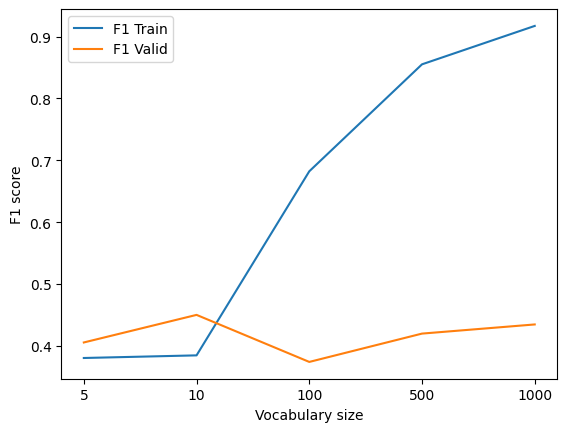

In [ ]:
def do_tfidf_prediction(df, max_features):
    vectors_train, labels_train = get_tfidf_vectors_and_labels(df, split="Train", max_features = max_features)
    vectors_valid, labels_valid = get_tfidf_vectors_and_labels(df, split="Valid", max_features = max_features)

    tfidf_classifier = LogisticRegression().fit(vectors_train, labels_train)
    predictions_train = tfidf_classifier.predict(vectors_train)
    predictions_valid = tfidf_classifier.predict(vectors_valid)
    f1_train = f1_score(labels_train, predictions_train, average='macro') #or weighted if you'd like!
    f1_valid = f1_score(labels_valid, predictions_valid, average='macro') #or weighted if you'd like!
    #    accuracy = (predictions_valid == labels_valid).sum()/len(predictions_valid)
    return f1_train, f1_valid

f1_scores_train = []
f1_scores_valid = []
max_features_array = [5,10,100,500,1000]
for max_features in max_features_array:
    f1_train, f1_valid = do_tfidf_prediction(df, max_features = max_features)
    f1_scores_train.append(f1_train)
    f1_scores_valid.append(f1_valid)

plt.plot(np.arange(len(max_features_array)),f1_scores_train,label="F1 Train")
plt.plot(np.arange(len(max_features_array)),f1_scores_valid,label="F1 Valid")
plt.xticks(np.arange(len(max_features_array)),max_features_array)
plt.xlabel("Vocabulary size")
plt.ylabel("F1 score")
plt.legend()

**Question**: What is the optimal value for max_features? Evaluate the classifier on the test set for that best value.



In [ ]:
best_max_features = None
best_f1_valid = 0.0

for max_features in max_features_array:
    f1_train, f1_valid = do_tfidf_prediction(df, max_features=max_features)
    f1_scores_train.append(f1_train)
    f1_scores_valid.append(f1_valid)

    # Check if current max_features gives a better F1 score on the validation set
    if f1_valid > best_f1_valid:
        best_f1_valid = f1_valid
        best_max_features = max_features

# Print the best_max_features
print("Optimal max_features:", best_max_features)

# Evaluate the classifier on the test set using the best_max_features
f1_train_best, f1_test_best = do_tfidf_prediction(df, max_features=best_max_features)

# Print the F1 score on the test set
print("F1 score on the test set with optimal max_features:", f1_test_best)


Optimal max_features: 10
F1 score on the test set with optimal max_features: 0.45009620009620016


The F1 score in this scenario is 0.45

**Question**: What features would you use if you were designing a linear classifier by hand?

**ANSWER**:

If I were designing a linear classifier by hand for predicting the year of articles based on abstracts, I would consider using features such as:
- Word presence or frequency, including unigrams and n-grams.
- Term Frequency-Inverse Document Frequency (TF-IDF).
- Sentence or document length.
- Part-of-speech (POS) tags.
- Temporal information related to publication date.
- Topic modeling features.
- Named Entity Recognition (NER).
- Punctuation and special characters.
- Domain-specific features, if applicable.

The choice of features would depend on the characteristics of the dataset and the hypothesis about temporal vocabulary change.

**Bonus**: Create a custom linear classifier based on your answer to the previous question. How does it perform in comparison to the TF-IDF baselines?

# BERT for Text Classification

We will now use a more sophisticated classification model, BERT. BERT (read more [here](https://arxiv.org/abs/1810.04805)) is a Transformer network (read more [here](https://arxiv.org/abs/1706.03762)). That means that it is a deep neural network in which each layer is actual comprised of a Transformer block, whose architecture is described in the linked paper - read more about it in this illustration [here](https://jalammar.github.io/illustrated-transformer/).

BERT is useful for text classification because it generates a latent representation for every input token based on its context. The output of BERT is there an $Nx768$ dimensional matrix, where $N$ is the number of tokens in the sequence input, and 768 is the size of token vectors produced by BERT. (Note: other models use different sized representations. The larger the representation, the more precise they can be, but also the more resources they require to both train and evaluate). We can then use these latent representations as inputs to a downstream task (such as sentence classification).

We perform sentence classification by evaluating the special classification token that we insert at the very beginning of sentences before passing them to BERT. The self-attention mechanism (see the previously linked articles for more information) allows for a latent representation of the classifier token to reflect the input text as a whole.

We will be using the following tools & resources for Python:
- [PyTorch](https://pytorch.org/docs/stable/index.html) : an open-source library for machine learning
- [transformers](https://huggingface.co/docs/transformers/index) by [Hugging Face](https://huggingface.co/): a Pytorch-based library for automatic language processing and in particular Transformer-type neural models (such as BERT)
- [tokenizers](https://huggingface.co/docs/tokenizers/python/latest/), also provided by Hugging Face: a Pytorch-based library for tokenisation, explicitly designed to work with the Transformers library

In [ ]:
!pip install transformers tokenizers
import torch
import transformers

Training our neural network requires a lot of matrix calculations. If available, we can use a graphics processor (GPU) to perform these calculations faster. On Colab, you can use a GPU by clicking on Runtime -> Change runtime type and then selecting the "GPU" option from the drop-down Hardware Accelerator menu.

In [ ]:
if torch.cuda.is_available():
    print('GPU available!')
    device = torch.cuda.current_device()
else:
    print('GPU unavailable - CPU will be used for all calculations')
    device = None

GPU available!


For our use case, we will use a pre-trained bio-medical BERT model. That means someone else has pre-trained it on bio-medical texts and provided that model for public use. That is very convenient - the pre-training step is very time-consuming, but necessary in order to use for down-stream tasks. You can think of it analogously to a human brain - when you are born, your brain doesn't know very much yet, so it would be very difficult to teach you complex tasks; however, an adult's brain has already been "pre-trained" with knowledge, and can thus learn a complex downstream task. The architecture of the two brains is, for the purpose of this analogy, identical, but the information stored in their synapses is different.

 Let's start with the model PubMedBert (read about it [here](https://huggingface.co/microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract)). It has been trained on abstracts from PubMed! (Note that there are plenty of bio-medical BERT models, each with slightly different architecture and slightly different training data, all of which perform roughly equally well on most benchmarks. Check out the PubMedBert paper to understand how one reaches that conclusion. As a bonus, try repeating the following section using [BlueBERT](https://huggingface.co/bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16)).

In [ ]:
#huggingface name for the model
model_name = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract"

The first step in using BERT for down-stream tasks is to tokenize the text the way BERT expects. The tokenizer takes a piece of text and transforms it into indices - indices in a fixed vocabulary. During pre-training, the tokenizer learns which words are most important, and puts them in its vocabulary (read more about that [here](https://albertauyeung.github.io/2020/06/19/bert-tokenization.html/)). The pre-trained tokenizer thusly first returns a list of indices when given an input string.

In order to use our GPUs most efficiently, it is often useful to process multiple pieces of text in parallel (in batches). Therefore, we need each item in the batch to be the same length; therefore, we must set a maximum number of tokens for our tokenizer. That way, if there are any too long texts, it cuts them off; texts that are too short are padded with filler. In order to tell BERT which tokens are filler padding, the tokenizer also returns a list of ones and zeros, indicating which items in the list are padding. In practice, the maximum document length should not be arbitrarily large, in order not to pass too much filler to the GPU, but not too small, in order not to lop off important tokens!

In [ ]:
# Load tokenizer directly
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, )

MAX_LEN=128 #a typical value for short documents like abstracts

tokenizer(["My name is Pierre",
           "Hello hello hello Hello hello hello hello."],
          truncation=True,
          padding='max_length',
          max_length=MAX_LEN)
#note the zeros in the "attention_mask"; these correspond to padding!

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

{'input_ids': [[2, 2493, 10474, 1744, 17410, 1027, 1698, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 3018, 5368, 3018, 5368, 3018, 5368, 3018, 5368, 3018, 5368, 3018, 5368, 3018, 5368, 17, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

We can tokenize an entire corpus:

In [ ]:
def do_tokenisation(texts, max_length):
    if not texts:  # Check if texts is empty
        return None

    tokeniser_output = tokenizer(
        texts,
        padding='max_length',  # pad shorter sequences to max_length
        truncation=True,  # truncate longer sequences to max_length
        max_length=max_length
    )

    for encoding in tokeniser_output:
        tokeniser_output[encoding] = torch.tensor(tokeniser_output[encoding])

    return tokeniser_output

train_tokeniser_output = do_tokenisation(df[df.Split == "Train"].Abstract_Cleaned.tolist(), MAX_LEN)
valid_tokeniser_output = do_tokenisation(df[df.Split == "Valid"].Abstract_Cleaned.tolist(), MAX_LEN)
test_tokeniser_output = do_tokenisation(df[df.Split == "Test"].Abstract_Cleaned.tolist(), MAX_LEN)

Let's have a look at an example of the encodings produced by the tokenizer.

In [ ]:
batch_idx = 5
original_sentence = df.Abstract_Cleaned[batch_idx]
print(f'Input sentence:\n{original_sentence}\n')
tokens = train_tokeniser_output.tokens(batch_idx)
print(f'Tokens:\n{tokens}\n')
input_ids = train_tokeniser_output['input_ids'][batch_idx]
print(f'Input IDs:\n{input_ids}\n')
attention_mask = train_tokeniser_output['attention_mask'][batch_idx]
print(f'Attention Mask:\n{attention_mask}\n')

Input sentence:
U S government project bet big intranasal vaccine monoclonal antibody omit ambitious approach 

Tokens:
['[CLS]', 'current', 'vaccine', 'tailor', 'combat', 'future', 'sars', 'cov', 'variant', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

**Question**: Which are the special tokens introduced by the tokenizer, and what do they represent?

**Answer**:

Special Tokens:

[CLS]: This token stands for "classification" and is added at the beginning of each sequence.
[SEP]: This token separates sentences or different parts of the input sequence. It indicates the end of a sequence.

**Question**: Why do some tokens start with ##?

**ANSWER**:

Tokens starting with ## are subwords. BERT tokenizes words into subwords when needed, especially for long or rare words. When a word is split into subwords, the subwords are prefixed with ## to indicate that they are part of the same original word.

**Question**: What is the smallest possible value for MAX_LEN that doesn't cut off any tokens in our corpus? Set MAX_LEN to that value!

**ANSWER**:

The smallest possible value for MAX_LEN that doesn't cut off any tokens in the corpus is the length of the longest sequence in the dataset. This can be found by examining the lengths of all tokenized sequences and selecting the maximum length.

In [ ]:
max_len_corpus = max(len(tokenizer.encode(text)) for text in df['Abstract_Cleaned'])
print("Maximum length in the corpus:", max_len_corpus)


Maximum length in the corpus: 153


## Language Model

In this section we will use the Hugging Face API to load the pre-trained weights of a transformer language model for inference.

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification
#AutoModelForSequenceClassification is an API that appends a linear classifer layer to
#the classifier token of a BERT network. Alternately, one can do this onseself in torch
#by creating a new class.

The ``config`` attribute contains hyperparameter values including vocabulary size, dropout probabilities, and architectural specifications; feel free to inspect them and try to understand what they mean and how they relate to the course material.

In [ ]:
model_config = AutoConfig.from_pretrained(model_name)
print(model_config)

BertConfig {
  "_name_or_path": "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



By default, the output size of the classification layer (corresponding to the number of different classes we want to identify) is 2. However, we have four years to classify, so we have a 4-class classification problem. This means we need to tell the model to expect 4 different class labels and adjust its output size accordingly. We do this by setting the `num_labels` configuration parameter.

In [ ]:
model_config.num_labels = 4

The ``model`` object we use here is an instantiation of the pre-trained PubMedBert model with an extra classification layer added.

In [ ]:
model = AutoModelForSequenceClassification.from_config(model_config)

### Optimiser
Neural networks require an optimisation strategy to implement backpropagation. We will use the [Adam](https://arxiv.org/pdf/1412.6980.pdf) algorithm, a widely-used method for transformer architectures.

In [ ]:
from transformers import AdamW

At this point in the implementation, we choose the learning rate to use in backpropagation: a parameter that controls the step sizes taken across the loss landscape by the optimiser at each step of training. This is a hyperparameter that has no _a priori_ optimal value; you can play around with the value to see how it affects the performance of our classifier.

In [ ]:
# the constructor function requires the parameters of the language model and the learning rate as input
optimizer = AdamW(tuple(model.parameters()), lr=2e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Custom Datasets & Data Loaders
For efficiency, we will use the Pytorch ``DataLoader`` object to pass the tokens to the model.

In [ ]:
from torch.utils.data import Dataset, DataLoader

For most Pytorch projects, you will need to define a custom dataset class that subclasses the built-in one.

In [ ]:
# here we define a simple subclass of the Pytorch Dataset object: the DataLoader by default will access the amount
# of data points stored by instances of this subclass, as well as indexing it, so we have to overwrite the __len__
# and __getitem__ methods to make sure it will behave as we would like

class ClassificationDataset(Dataset):
    def __init__(self, df, split):
        super().__init__()
        self.df = df[df.Split==split]
        self.tokeniser_output = do_tokenisation(self.df.Abstract_Cleaned.tolist(), MAX_LEN)
        self.labels = self.df.Year.values-2020

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        input_ids, att_mask = self.tokeniser_output["input_ids"][idx], self.tokeniser_output["attention_mask"][idx]
        label = self.labels[idx]
        return (input_ids, att_mask, label)

train_dataset = ClassificationDataset(df,"Train")
valid_dataset = ClassificationDataset(df,"Valid")

At this point we select another hyperparameter, the _batch size_, i.e. the number of sentences to process at each training step. A higher batch size will result in more effective backpropagation steps, as the model will have "seen" more training examples before calculating the adjustment to make to its parameters, but a lower batch size will result in more efficient training as not as many examples need to be loaded into memory at once.

In [ ]:
BATCH_SIZE = 4

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

## Training a Classifier
To fine-tune the PubMedBert word embeddings for our document classification task, we use the ``[CLS]`` token from the final layer of the transformer neural network to predict the relevant class for each sentence. To output class probabilities based on the word embedding vectors, a linear prediction layer is stacked on top of the transformer network, which will learn weight parameters $w$ that correspond to the optimal transformation of the ``[CLS]`` vector into a vector of scores for each class in the output space (usually called _logits_). To generate class probabilities from the logit vector, the [softmax function](https://en.wikipedia.org/wiki/Softmax_function) is applied:

$$
\phi_w:\mathbb{R}^{d_{\text{EMB}}}\rightarrow\mathbb{R}^{d_{\text{CLASS}}} \\
\text{Classifier}\left(x_{\text{CLS}}\right)=\text{softmax}\left(\phi_w\left(x_{\text{CLS}}\right)\right)
$$

For the model we use in this tutorial, we have embedding dimension $d_{\text{EMB}}=768$ and because we have ten hallmarks of cancer plus the absence of a hallmark, we have output dimension $d_{\text{CLASS}}=4$.

To predict a single class, however, we just need to pick out the dimension of the logit vector with the highest score:

$$\text{Predicted Class}=\text{argmax}\left(\phi\left(x_{\text{CLS}}\right)\right)$$

### Using GPUs
Graphical Processing Units (GPUs) are optimised for very fast parallel matrix calculations and are thus widely used for training neural networks. In practice, for models of the scale of BERT, GPUs are necessary to be able to perform experiments in reasonable timeframes (although pre-training still often requires several days of runtime on multiple GPUs).

In order to use ther GPU, we have to explicitly tell torch to move our data onto the GPU for faster calculation. Make sure that all the data that the GPU requires is passed correctly - a common bug in writing PyTorch code is to have some data (say the labels) on the CPU and other (say the model) on the GPU - this is incompatible. We tell torch to move the model onto the GPU for quicker calculation:

In [ ]:
model.to(device)
#this is what our BERT model looks like! Note the linear classifier layer on the end.

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

The last important aspect to define is how we will teach this model. We perform gradient descent after each batch - i.e., we tell the model how to change its weights in order to minimize the loss for that batch. However, to do this, we must explicitly define the loss. For classification tasks, a popular choice is the cross-entropy loss:

$$\text{Loss}_{ce}=-\sum\limits_{c = 1..C}\ell_c\log(p_c)$$

Where $\ell_c$ is the gold value for class $c$, and $p_c$ the prediction for class $c$: $p_c = \text{softmax}\left(\phi_w\left(x\right)\right)$.

**Question**: $\ell_c\log(p_c) = c'$ for all but one $c' \in [1..C]$. What is $c'$, and why is this true?

**ANSWER**:

The value \( c' \) in the expression \( \ell_c \log(p_c) = c' \) corresponds to the index of the correct or gold class. In the context of the cross-entropy loss for classification tasks, the expression \( \ell_c \log(p_c) \) represents the negative log-likelihood of the true class.

Here's why \( c' \) is true:

1. \( \ell_c \) is a one-hot encoded vector representing the true class. It has a value of 1 for the true class and 0 for all other classes.

2. \( p_c \) is the predicted probability for class \( c \) after applying the softmax function to the logits \( \phi_w(x) \).

3. In the one-hot encoded vector \( \ell_c \), there is only one non-zero element (1) corresponding to the true class. Let's call this element \( \ell_{c'} \), where \( c' \) is the index of the true class.

4. For the true class (\( c = c' \)), \( \ell_c \) is 1, and \( \log(p_c) \) becomes \( \log(p_{c'}) \). For all other classes (\( c \neq c' \)), \( \ell_c \) is 0, and \( \log(p_c) \) becomes \( \log(p_c) \) for those classes.

5. Therefore, the only non-zero term in the summation \( -\sum_{c=1}^{C} \ell_c \log(p_c) \) is \( -\ell_{c'} \log(p_{c'}) \), where \( c' \) is the index of the true class.

In summary, \( c' \) is the index of the correct (true) class, and this expression ensures that the loss penalizes the model more when its prediction diverges from the true class, in accordance with the negative log-likelihood.

Now, we are (finally) ready to start training our classifier. The first thing to do is to decide how many epochs (full passes over the dataset) we would like to use. For fine-tuning BERT models, we usually consider that the model pre-training has already instilled it with a lot of the knowledge necessary to carry out the task, so we train for relatively few (2-5) epochs, but this heuristic does not necessarily apply to all problems and for many domain-specific tasks (such as this one) it may be beneficial to increase this hyperparameter. In particular, given the relative paucity of data, we train initially for 20 epochs.

In [ ]:
N_EPOCHS = 20

# progress bar for batches
from tqdm import tqdm

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

def train_model(model=None):
    total_train_f1 = []
    total_valid_f1 = []
    total_train_loss = []
    total_valid_loss = []

    # reset the model if you run this cell more than once!
    if model is None:
        model = AutoModelForSequenceClassification.from_config(model_config).to(device)
    optimizer = AdamW(tuple(model.parameters()), lr=2e-5)

    for epoch in range(N_EPOCHS):
        model.train()
        train_f1 = []
        train_loss = []
        valid_f1 = []
        valid_loss = []
        print(f'Epoch {epoch}, training...')

        # Training data
        for input_ids, attention_masks, labels in tqdm(train_dataloader):
            # forward pass
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)
            outputs = model(
                input_ids=input_ids, attention_mask=attention_masks, labels=labels
            )

            # backpropagation
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # metrics
            predictions = outputs.logits.argmax(-1)
            f1 = f1_score(labels.cpu(), predictions.cpu(), average='macro').item()  # or weighted if you'd like!
            logits = outputs.logits.cpu()  # retrieve data from the GPU
            labels = labels.cpu()
            predictions = logits.argmax(-1)
            train_f1.append(f1)
            train_loss.append(loss.item())

        epoch_f1_train = sum(train_f1) / len(train_f1)
        epoch_loss_train = sum(train_loss) / len(train_loss)
        total_train_f1.append(epoch_f1_train)
        total_train_loss.append(epoch_loss_train)

        model.eval()
        print(f'Epoch {epoch}, evaluating...')
        # Validation data
        for input_ids, attention_masks, labels in tqdm(valid_dataloader):
            with torch.no_grad():  # this context manager deactivates the backpropagation-related elements of the tensors
                outputs = model(
                    input_ids=input_ids.to(device), attention_mask=attention_masks.to(device)
                )
                loss = criterion(outputs.logits, labels.to(device))
                predictions = outputs.logits.argmax(-1)
                f1 = f1_score(labels.cpu(), predictions.cpu(), average='macro').item()
                valid_f1.append(f1)
                valid_loss.append(loss.item())

        epoch_f1_valid = sum(valid_f1) / len(valid_f1)
        epoch_loss_valid = sum(valid_loss) / len(valid_loss)
        total_valid_f1.append(epoch_f1_valid)
        total_valid_loss.append(epoch_loss_valid)
        print(f'Epoch {epoch}: training set F1={round(epoch_f1_train, 3)}, validation set F1={round(epoch_f1_valid, 3)}')

    return model, total_train_f1, total_valid_f1, total_train_loss, total_valid_loss

model, total_train_f1, total_valid_f1, total_train_loss, total_valid_loss = train_model()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0, training...


100%|██████████| 67/67 [00:11<00:00,  5.89it/s]


Epoch 0, evaluating...


100%|██████████| 9/9 [00:00<00:00, 24.19it/s]


Epoch 0: training set F1=0.727, validation set F1=0.259
Epoch 1, training...


100%|██████████| 67/67 [00:08<00:00,  7.64it/s]


Epoch 1, evaluating...


100%|██████████| 9/9 [00:00<00:00, 24.56it/s]


Epoch 1: training set F1=0.73, validation set F1=0.259
Epoch 2, training...


100%|██████████| 67/67 [00:08<00:00,  7.63it/s]


Epoch 2, evaluating...


100%|██████████| 9/9 [00:00<00:00, 37.36it/s]


Epoch 2: training set F1=0.74, validation set F1=0.259
Epoch 3, training...


100%|██████████| 67/67 [00:08<00:00,  8.03it/s]


Epoch 3, evaluating...


100%|██████████| 9/9 [00:00<00:00, 38.14it/s]


Epoch 3: training set F1=0.725, validation set F1=0.259
Epoch 4, training...


100%|██████████| 67/67 [00:07<00:00,  9.52it/s]


Epoch 4, evaluating...


100%|██████████| 9/9 [00:00<00:00, 38.17it/s]


Epoch 4: training set F1=0.656, validation set F1=0.259
Epoch 5, training...


100%|██████████| 67/67 [00:07<00:00,  9.35it/s]


Epoch 5, evaluating...


100%|██████████| 9/9 [00:00<00:00, 38.25it/s]


Epoch 5: training set F1=0.575, validation set F1=0.259
Epoch 6, training...


100%|██████████| 67/67 [00:07<00:00,  9.31it/s]


Epoch 6, evaluating...


100%|██████████| 9/9 [00:00<00:00, 36.99it/s]


Epoch 6: training set F1=0.523, validation set F1=0.259
Epoch 7, training...


100%|██████████| 67/67 [00:07<00:00,  9.27it/s]


Epoch 7, evaluating...


100%|██████████| 9/9 [00:00<00:00, 36.66it/s]


Epoch 7: training set F1=0.426, validation set F1=0.259
Epoch 8, training...


100%|██████████| 67/67 [00:07<00:00,  9.13it/s]


Epoch 8, evaluating...


100%|██████████| 9/9 [00:00<00:00, 36.47it/s]


Epoch 8: training set F1=0.614, validation set F1=0.259
Epoch 9, training...


100%|██████████| 67/67 [00:07<00:00,  9.11it/s]


Epoch 9, evaluating...


100%|██████████| 9/9 [00:00<00:00, 35.99it/s]


Epoch 9: training set F1=0.561, validation set F1=0.259
Epoch 10, training...


100%|██████████| 67/67 [00:07<00:00,  8.99it/s]


Epoch 10, evaluating...


100%|██████████| 9/9 [00:00<00:00, 35.50it/s]


Epoch 10: training set F1=0.637, validation set F1=0.259
Epoch 11, training...


100%|██████████| 67/67 [00:07<00:00,  8.91it/s]


Epoch 11, evaluating...


100%|██████████| 9/9 [00:00<00:00, 34.36it/s]


Epoch 11: training set F1=0.672, validation set F1=0.259
Epoch 12, training...


100%|██████████| 67/67 [00:07<00:00,  8.79it/s]


Epoch 12, evaluating...


100%|██████████| 9/9 [00:00<00:00, 34.23it/s]


Epoch 12: training set F1=0.589, validation set F1=0.259
Epoch 13, training...


100%|██████████| 67/67 [00:07<00:00,  8.68it/s]


Epoch 13, evaluating...


100%|██████████| 9/9 [00:00<00:00, 33.49it/s]


Epoch 13: training set F1=0.009, validation set F1=0.307
Epoch 14, training...


100%|██████████| 67/67 [00:07<00:00,  8.71it/s]


Epoch 14, evaluating...


100%|██████████| 9/9 [00:00<00:00, 33.78it/s]


Epoch 14: training set F1=0.066, validation set F1=0.307
Epoch 15, training...


100%|██████████| 67/67 [00:07<00:00,  8.78it/s]


Epoch 15, evaluating...


100%|██████████| 9/9 [00:00<00:00, 33.73it/s]


Epoch 15: training set F1=0.076, validation set F1=0.307
Epoch 16, training...


100%|██████████| 67/67 [00:07<00:00,  8.57it/s]


Epoch 16, evaluating...


100%|██████████| 9/9 [00:00<00:00, 34.35it/s]


Epoch 16: training set F1=0.066, validation set F1=0.307
Epoch 17, training...


100%|██████████| 67/67 [00:07<00:00,  8.95it/s]


Epoch 17, evaluating...


100%|██████████| 9/9 [00:00<00:00, 35.41it/s]


Epoch 17: training set F1=0.072, validation set F1=0.307
Epoch 18, training...


100%|██████████| 67/67 [00:08<00:00,  7.74it/s]


Epoch 18, evaluating...


100%|██████████| 9/9 [00:00<00:00, 36.16it/s]


Epoch 18: training set F1=0.073, validation set F1=0.307
Epoch 19, training...


100%|██████████| 67/67 [00:07<00:00,  8.99it/s]


Epoch 19, evaluating...


100%|██████████| 9/9 [00:00<00:00, 35.44it/s]

Epoch 19: training set F1=0.092, validation set F1=0.307


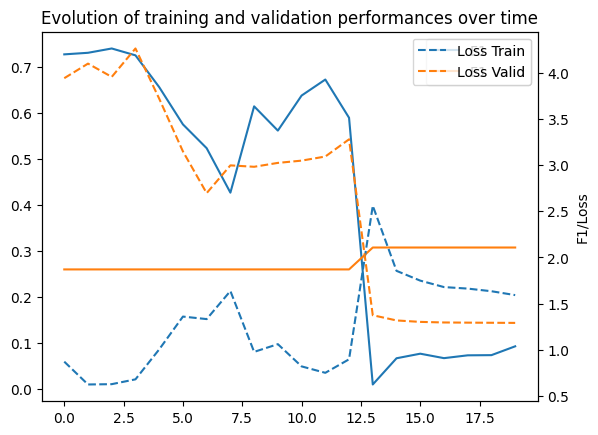

In [ ]:
ax = plt.gca()
twinx = ax.twinx()
ax.plot(total_train_f1,label="F1 Train")
ax.plot(total_valid_f1,label="F1 Valid")
twinx.plot(total_train_loss,label="Loss Train", linestyle="dashed")
twinx.plot(total_valid_loss,label="Loss Valid", linestyle="dashed")
plt.xlabel("Epoch")
plt.ylabel("F1/Loss")
plt.title("Evolution of training and validation performances over time")
ax.legend()
twinx.legend()

**Question**: Describe what happens over the course of the 20 epochs of training

**ANSWER**: Over the course of the 20 epochs of training, the model undergoes multiple iterations through the training dataset to learn patterns and features. During each epoch, it performs a forward and backward pass, updating its weights to minimize the loss. The training and validation metrics, such as F1 score and loss, are computed and monitored for performance evaluation.


**Question**: Repeat the training - are the results the same? Why (or why not)?

**ANSWER**: Even after repeating the training, the results are the same, it is probably because factors like fixed random seed for initialization or deterministic processes during training, such as data shuffling, are being kept constant.

**Question**: Train for 20 more epochs - what starts to occur?

**ANSWER**:

Training for 20 more epochs leads to overfitting, where the model becomes increasingly tailored to the training data and starts to perform poorly on new, unseen data (validation set). The model exhibits a decrease in validation performance, indicating that it is memorizing the training set rather than generalizing well to new examples.

**Question**: Discuss the benefits and drawbacks of using the BERT model for this task. How might this change for a more complicated classification task?

**ANSWER**:

**Benefits of Using BERT:**
1. **Semantic Understanding:** BERT excels in capturing nuanced semantic relationships and understanding words in their contextual meaning, enhancing its performance in tasks that demand a deep comprehension of language.
2. **Pre-trained Representations:** Leveraging pre-trained representations enables BERT to transfer knowledge from a vast dataset, proving advantageous in scenarios with limited labeled data.
3. **Token-level Attention:** BERT's token-level attention mechanism allows it to focus on relevant segments of the input sequence, contributing to more informed predictions.

**Drawbacks of Using BERT:**
1. **Computational Cost:** BERT comes with a high computational cost, both during training and inference, necessitating substantial computing resources.
2. **Large Model Size:** The extensive number of parameters in BERT models results in larger storage requirements and potentially slower processing times for both training and inference.
3. **Interpretability Challenges:** BERT models are often perceived as "black boxes," making it challenging to interpret the decision-making process and understand the factors influencing predictions.

**Adaptations for More Complicated Tasks:**
1. **Task-Specific Fine-Tuning:** Fine-tuning BERT on task-specific data becomes essential for addressing the intricacies of more complex tasks.
2. **Model Size and Training Data:** Depending on task complexity and available labeled data, consideration may be given to larger BERT models or extended training epochs.
3. **Ensemble Approaches:** Combining predictions from multiple BERT models or employing ensemble methods can further enhance performance on intricate tasks.



**Question**: Use the sklearn [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for the predictions from PubMedBert, as well as for the TF-IDF classifier. Describe the pattern you observe.

100%|██████████| 9/9 [00:00<00:00, 35.79it/s]


Confusion Matrix for PubMedBert:
[[ 0 12  0  0]
 [ 0  8  0  0]
 [ 0 12  0  0]
 [ 0  2  0  0]]


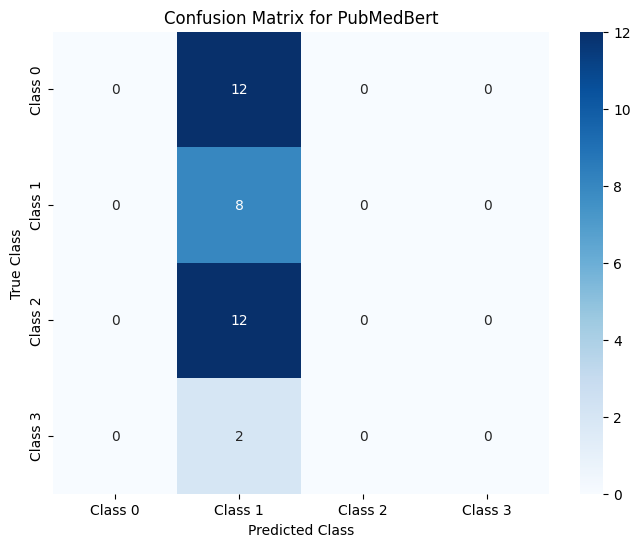

In [ ]:
#todo: implement confusion matrix
#For PubMedBert
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to get predictions from the model
def get_predictions(model, dataloader):
    predictions = []
    true_labels = []

    model.eval()
    with torch.no_grad():
        for input_ids, attention_masks, labels in tqdm(dataloader):
            outputs = model(
                input_ids=input_ids.to(device), attention_mask=attention_masks.to(device)
            )
            predictions.extend(outputs.logits.argmax(-1).cpu().numpy())
            true_labels.extend(labels.numpy())

    return np.array(predictions), np.array(true_labels)

# Get predictions for the test set
test_dataset = ClassificationDataset(df, "Test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
predictions_bert, true_labels_bert = get_predictions(model, test_dataloader)

# Confusion matrix for PubMedBert
cm_bert = confusion_matrix(true_labels_bert, predictions_bert)
print("Confusion Matrix for PubMedBert:")
print(cm_bert)

# Visualize the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"],
            yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.title("Confusion Matrix for PubMedBert")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()



Confusion Matrix for TF-IDF:
[[5 6 1 0]
 [1 5 2 0]
 [0 6 6 0]
 [0 0 2 0]]


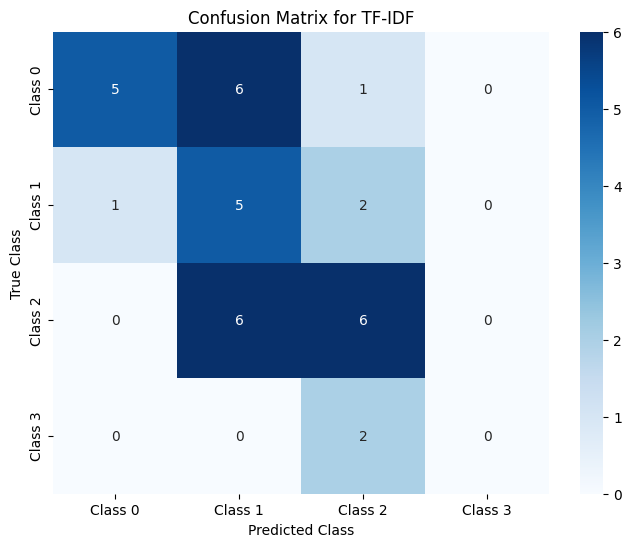

In [ ]:
#FOR TF-IDF
# Function to get predictions from the TF-IDF model
def get_tfidf_predictions(df, split="Test", max_features=100):
    vectors_train, labels_train = get_tfidf_vectors_and_labels(df, split="Train", max_features=max_features)
    vectors_test, labels_test = get_tfidf_vectors_and_labels(df, split=split, max_features=max_features)

    tfidf_classifier = LogisticRegression().fit(vectors_train, labels_train)
    predictions_test = tfidf_classifier.predict(vectors_test)

    return predictions_test, labels_test

# Get predictions for the test set using TF-IDF
predictions_tfidf, true_labels_tfidf = get_tfidf_predictions(df, split="Test", max_features=best_max_features)

# Confusion matrix for TF-IDF
cm_tfidf = confusion_matrix(true_labels_tfidf, predictions_tfidf)
print("\nConfusion Matrix for TF-IDF:")
print(cm_tfidf)

# Visualize the confusion matrix using Seaborn's heatmap for TF-IDF
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"],
            yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.title("Confusion Matrix for TF-IDF")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


**Bonus**: Add a learning rate scheduler to the neural training loop, such as (this one)[https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html]. What is the purpose of this? Does this help training?